In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gzip
import json
import glob
from collections import Counter

In [2]:
df = pd.read_csv("../all_data_minimal_with_hashtags.csv", parse_dates=["created_at"], dtype={"author_id": str, "in_reply_to_user_id": str}, usecols=["created_at", "author_id", "in_reply_to_user_id", "hashtags"])
df

,created_at,author_id,in_reply_to_user_id,hashtags
0,2022-04-01 04:58:38+00:00,1385729645740449804,1500536286591033351,[]
1,2022-04-01 04:56:47+00:00,4501930040,NaN,[]
2,2022-04-01 04:56:23+00:00,28729354,3173688997,[]
3,2022-04-01 04:55:32+00:00,4501930040,1248074962377699328,[]
4,2022-04-01 04:55:00+00:00,4501930040,NaN,[]
...,...,...,...,...
14060530,2021-12-01 05:38:24+00:00,25444322,NaN,['#GetVaccinated']
14060531,2021-12-01 05:37:57+00:00,25444322,NaN,[]
14060532,2021-12-01 05:25:36+00:00,40091601,48928145,[]
14060533,2021-12-01 05:23:12+00:00,40091601,732409522778742784,[]


In [3]:
df_covid19 = df[df['hashtags'].apply(lambda hashtags: "#COVID19" in hashtags)]
df_covid19

,created_at,author_id,in_reply_to_user_id,hashtags
388,2022-03-31 20:22:08+00:00,218538023,NaN,"['#COVID19', '#flu', '#influenza', '#COVID19Aus']"
393,2022-03-31 20:20:44+00:00,218538023,NaN,['#COVID19']
395,2022-03-31 20:19:45+00:00,218538023,NaN,['#COVID19']
1063,2022-03-31 12:29:30+00:00,218538023,NaN,['#COVID19']
1065,2022-03-31 12:28:10+00:00,218538023,NaN,['#COVID19']
...,...,...,...,...
14060112,2021-12-02 15:21:10+00:00,15570694,NaN,['#COVID19']
14060159,2021-12-02 12:24:23+00:00,982564830,NaN,['#COVID19']
14060290,2021-12-01 22:02:19+00:00,982564830,NaN,"['#DrOz', '#COVID19']"
14060330,2021-12-01 19:50:52+00:00,982564830,NaN,"['#Parents', '#COVID19']"


<Axes: xlabel='created_at'>

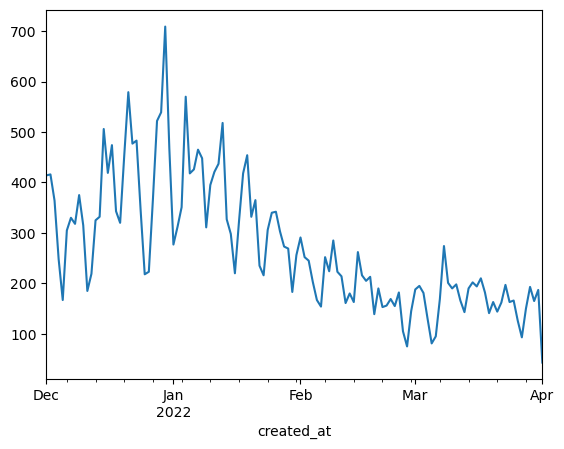

In [4]:
df_covid19.set_index("created_at").resample("D").size().plot()

In [5]:
user_post_count = df_covid19["author_id"].value_counts().rename_axis("author_id").rename("post_count").reset_index()
user_post_count

,author_id,post_count
0,118788479,1220
1,29097819,1065
2,736710115,820
3,4937061,588
4,38978291,573
...,...,...
1556,768695606223130624,1
1557,2513803810,1
1558,1069333070,1
1559,98269730,1


In [6]:
user_rr_count = df_covid19["in_reply_to_user_id"].value_counts().rename_axis("author_id").rename("received_retweets_count").reset_index()#.drop(0) # drop NaN
user_rr_count

,author_id,received_retweets_count
0,80483638,290
1,146569971,61
2,36167088,52
3,620136960,44
4,17919393,38
...,...,...
766,18149465,1
767,14124059,1
768,382386622,1
769,19368770,1


In [7]:
user_rrpp = user_rr_count.set_index('author_id').join(
    user_post_count.set_index('author_id'), how='outer'
).fillna(0)
user_rrpp['rr_per_post'] = user_rrpp['received_retweets_count'] / (user_rrpp['post_count'] + 1)
user_rrpp = user_rrpp.reset_index().sort_values(by='rr_per_post', ascending=False)
user_rrpp

,author_id,received_retweets_count,post_count,rr_per_post
327,1295803342162210817,21.0,0.0,21.0
917,20525702,19.0,0.0,19.0
894,19834403,15.0,0.0,15.0
1392,3180247177,13.0,0.0,13.0
308,1282853745945202688,11.0,0.0,11.0
...,...,...,...,...
958,21612122,0.0,6.0,0.0
957,2158643891,0.0,1.0,0.0
956,2157244796,0.0,23.0,0.0
955,21544108,0.0,2.0,0.0


In [8]:
user_rrpp_valid = user_rrpp[user_rrpp['author_id'].isin(user_post_count['author_id'])].sort_values(by='rr_per_post', ascending=False)
user_rrpp_valid

,author_id,received_retweets_count,post_count,rr_per_post
2011,80483638,290.0,400.0,0.723192
1899,720959701651996673,21.0,31.0,0.656250
738,169353953,4.0,6.0,0.571429
1475,344350643,1.0,1.0,0.500000
409,1352311853263671296,3.0,5.0,0.500000
...,...,...,...,...
1710,4819630852,0.0,13.0,0.000000
1711,48219360,0.0,252.0,0.000000
1712,482403268,0.0,11.0,0.000000
1713,4838743006,0.0,28.0,0.000000


In [9]:
selected_users_rrpp = user_rrpp_valid[user_rrpp_valid['rr_per_post'] > 0.1]
selected_users_rrpp

,author_id,received_retweets_count,post_count,rr_per_post
2011,80483638,290.0,400.0,0.723192
1899,720959701651996673,21.0,31.0,0.656250
738,169353953,4.0,6.0,0.571429
1475,344350643,1.0,1.0,0.500000
409,1352311853263671296,3.0,5.0,0.500000
752,17146256,1.0,1.0,0.500000
1500,359528910,1.0,1.0,0.500000
48,1047247402409840640,1.0,1.0,0.500000
1628,4311670299,1.0,1.0,0.500000
787,179226033,1.0,1.0,0.500000


In [10]:
user_last_tweet_df = df_covid19.groupby('author_id')['created_at'].max().reset_index().rename(columns={'created_at': 'last_tweet'})
user_last_tweet_df

,author_id,last_tweet
0,1003139946,2022-03-11 14:15:48+00:00
1,1004065528871247872,2022-03-31 00:55:08+00:00
2,1005142093369675777,2022-02-08 22:09:12+00:00
3,1006734899837980672,2022-01-27 22:22:55+00:00
4,100701580,2021-12-26 01:47:50+00:00
...,...,...
1556,995877126464303104,2021-12-08 16:11:50+00:00
1557,996423161053876224,2022-03-24 14:59:44+00:00
1558,99666729,2021-12-26 15:51:27+00:00
1559,997931370,2022-03-31 14:45:11+00:00


In [11]:
filtered_users = user_last_tweet_df[user_last_tweet_df["author_id"].isin( selected_users_rrpp["author_id"] )].sort_values(by='last_tweet', ascending=False)
filtered_users

,author_id,last_tweet
367,149197471,2022-04-01 03:52:00+00:00
1548,989320781799743488,2022-03-31 20:50:10+00:00
351,146569971,2022-03-31 20:00:11+00:00
1113,43369337,2022-03-31 16:09:52+00:00
1,1004065528871247872,2022-03-31 00:55:08+00:00
1461,877629044828667905,2022-03-31 00:07:57+00:00
1257,620136960,2022-03-30 20:22:23+00:00
1352,767945051787759616,2022-03-30 17:16:27+00:00
1019,36167088,2022-03-30 16:31:16+00:00
1386,80483638,2022-03-30 15:33:56+00:00


In [12]:
date_posts = df_covid19.set_index('created_at').resample('d').size().sort_index().reset_index(name='count')
date_posts

,created_at,count
0,2021-12-01 00:00:00+00:00,414
1,2021-12-02 00:00:00+00:00,416
2,2021-12-03 00:00:00+00:00,364
3,2021-12-04 00:00:00+00:00,248
4,2021-12-05 00:00:00+00:00,167
...,...,...
117,2022-03-28 00:00:00+00:00,150
118,2022-03-29 00:00:00+00:00,193
119,2022-03-30 00:00:00+00:00,165
120,2022-03-31 00:00:00+00:00,187


In [13]:
sorted_users_by_rrpp = [u for u in user_rrpp["author_id"] if u in filtered_users["author_id"].unique()]

In [14]:
sorted_filtered_users = filtered_users.set_index('author_id').loc[sorted_users_by_rrpp]['last_tweet'].reset_index()
sorted_filtered_users

,author_id,last_tweet
0,80483638,2022-03-30 15:33:56+00:00
1,720959701651996673,2022-02-08 23:01:34+00:00
2,169353953,2022-03-27 05:27:40+00:00
3,344350643,2022-01-25 21:37:47+00:00
4,1352311853263671296,2022-02-17 22:58:21+00:00
5,17146256,2021-12-25 16:40:26+00:00
6,359528910,2022-02-01 02:22:22+00:00
7,1047247402409840640,2021-12-28 20:52:12+00:00
8,4311670299,2022-02-05 14:19:36+00:00
9,179226033,2022-02-25 00:17:42+00:00


In [15]:
sorted_users_rrpp = user_rrpp.set_index('author_id').loc[sorted_users_by_rrpp]['rr_per_post']
sorted_users_rrpp

author_id
80483638               0.723192
720959701651996673     0.656250
169353953              0.571429
344350643              0.500000
1352311853263671296    0.500000
17146256               0.500000
359528910              0.500000
1047247402409840640    0.500000
4311670299             0.500000
179226033              0.500000
767945051787759616     0.470588
1457177169407393795    0.428571
26950458               0.400000
17919393               0.368932
620136960              0.360656
989313110602235904     0.333333
36167088               0.300578
898324652              0.285714
17018470               0.266667
1428158156098572291    0.250000
1004065528871247872    0.250000
877629044828667905     0.216783
20280574               0.215686
239666710              0.200000
3173246967             0.200000
149197471              0.200000
989320781799743488     0.200000
21833509               0.200000
19201304               0.200000
142843687              0.193548
1421182643375427584    0.16666

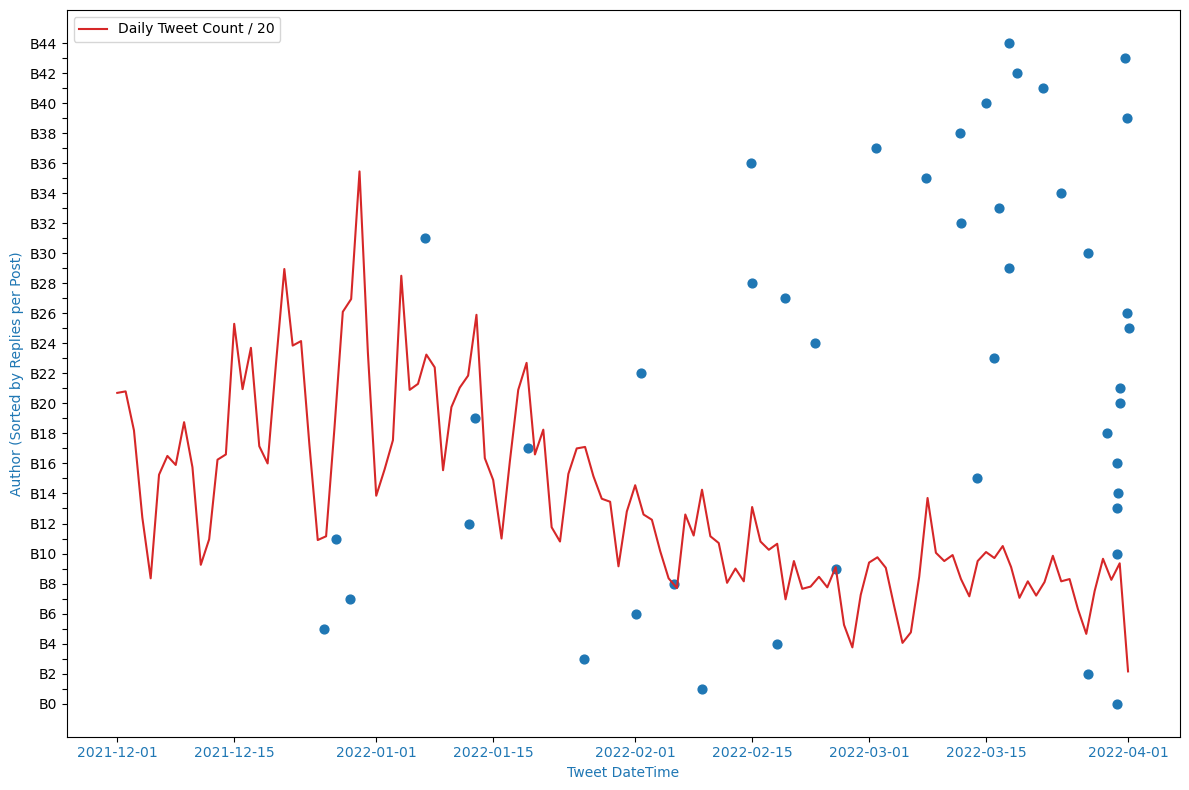

In [16]:
fig, ax1 = plt.subplots(figsize=(12,8))
color = 'tab:blue'
ax1.set_ylabel('Author (Sorted by Replies per Post)', color=color)
ax1.set_xlabel('Tweet DateTime', color=color)
yticklabels = []
for i, author in enumerate(sorted_filtered_users['author_id']):
    author_tweets = df_covid19[df_covid19['author_id'] == author].sort_values('created_at', ascending=False).head(1)
    ax1.scatter(author_tweets['created_at'], [author]*len(author_tweets), color=color, alpha=1, s=40)
    yticklabels.append(author)
ax1.tick_params(axis='x', labelcolor=color)
# Show every other user name for readability
yticks = ax1.get_yticks()
ax1.set_yticks(yticks)
ax1.set_yticklabels([f"B{i}" if i%2==0 else '' for i, name in enumerate(yticklabels)])
color = 'tab:red'
ax1.plot(date_posts['created_at'], date_posts['count']/20, color=color, label='Daily Tweet Count / 20')
ax1.legend(loc='upper left')
fig.tight_layout()
plt.savefig("covid19_user_last_tweet_vs_rrpp.png", dpi=300)
plt.show()

In [17]:
sorted_users_rrpp[:8]

author_id
80483638               0.723192
720959701651996673     0.656250
169353953              0.571429
344350643              0.500000
1352311853263671296    0.500000
17146256               0.500000
359528910              0.500000
1047247402409840640    0.500000
Name: rr_per_post, dtype: float64

In [18]:
sorted_filtered_users

,author_id,last_tweet
0,80483638,2022-03-30 15:33:56+00:00
1,720959701651996673,2022-02-08 23:01:34+00:00
2,169353953,2022-03-27 05:27:40+00:00
3,344350643,2022-01-25 21:37:47+00:00
4,1352311853263671296,2022-02-17 22:58:21+00:00
5,17146256,2021-12-25 16:40:26+00:00
6,359528910,2022-02-01 02:22:22+00:00
7,1047247402409840640,2021-12-28 20:52:12+00:00
8,4311670299,2022-02-05 14:19:36+00:00
9,179226033,2022-02-25 00:17:42+00:00


In [19]:
author_rrpp_data = pd.merge(sorted_users_rrpp, sorted_filtered_users, left_index=True, right_on='author_id').sort_values(by='rr_per_post', ascending=False)
author_rrpp_data

,rr_per_post,author_id,last_tweet
0,0.723192,80483638,2022-03-30 15:33:56+00:00
1,0.656250,720959701651996673,2022-02-08 23:01:34+00:00
2,0.571429,169353953,2022-03-27 05:27:40+00:00
3,0.500000,344350643,2022-01-25 21:37:47+00:00
4,0.500000,1352311853263671296,2022-02-17 22:58:21+00:00
5,0.500000,17146256,2021-12-25 16:40:26+00:00
6,0.500000,359528910,2022-02-01 02:22:22+00:00
7,0.500000,1047247402409840640,2021-12-28 20:52:12+00:00
8,0.500000,4311670299,2022-02-05 14:19:36+00:00
9,0.500000,179226033,2022-02-25 00:17:42+00:00


In [20]:
date_min = date_posts["created_at"].min()
date_max = date_posts["created_at"].max()
date_posts["timeline_norm"] = (date_posts["created_at"] - date_min) / (date_max - date_min)
date_posts

,created_at,count,timeline_norm
0,2021-12-01 00:00:00+00:00,414,0.000000
1,2021-12-02 00:00:00+00:00,416,0.008264
2,2021-12-03 00:00:00+00:00,364,0.016529
3,2021-12-04 00:00:00+00:00,248,0.024793
4,2021-12-05 00:00:00+00:00,167,0.033058
...,...,...,...
117,2022-03-28 00:00:00+00:00,150,0.966942
118,2022-03-29 00:00:00+00:00,193,0.975207
119,2022-03-30 00:00:00+00:00,165,0.983471
120,2022-03-31 00:00:00+00:00,187,0.991736


In [21]:
author_rrpp_data["last_tweet_norm"] = (author_rrpp_data["last_tweet"] - date_min) / (date_max - date_min)
author_rrpp_data["timeline_score"] = author_rrpp_data["rr_per_post"] * author_rrpp_data["last_tweet_norm"]
author_rrpp_data

,rr_per_post,author_id,last_tweet,last_tweet_norm,timeline_score
0,0.723192,80483638,2022-03-30 15:33:56+00:00,0.988831,0.715115
1,0.656250,720959701651996673,2022-02-08 23:01:34+00:00,0.578177,0.379429
2,0.571429,169353953,2022-03-27 05:27:40+00:00,0.960558,0.548890
3,0.500000,344350643,2022-01-25 21:37:47+00:00,0.461994,0.230997
4,0.500000,1352311853263671296,2022-02-17 22:58:21+00:00,0.652539,0.326269
5,0.500000,17146256,2021-12-25 16:40:26+00:00,0.204089,0.102044
6,0.500000,359528910,2022-02-01 02:22:22+00:00,0.513214,0.256607
7,0.500000,1047247402409840640,2021-12-28 20:52:12+00:00,0.230327,0.115164
8,0.500000,4311670299,2022-02-05 14:19:36+00:00,0.550388,0.275194
9,0.500000,179226033,2022-02-25 00:17:42+00:00,0.710845,0.355423


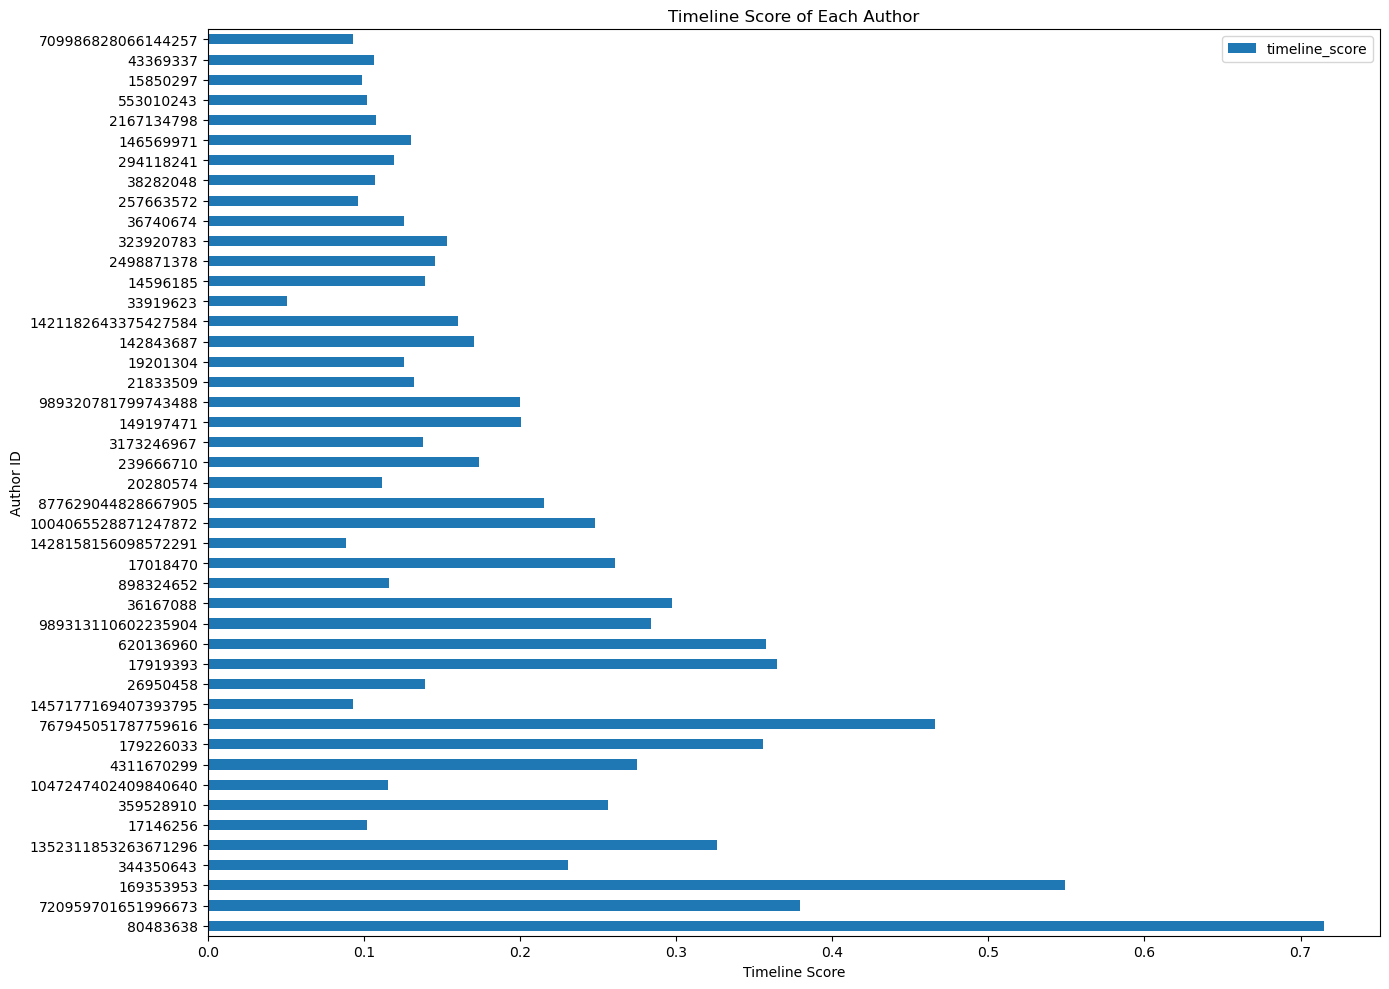

In [22]:
author_rrpp_data.plot(x='author_id', y='timeline_score', kind='barh', figsize=(14,10))
plt.xlabel('Timeline Score')
plt.ylabel('Author ID')
plt.title('Timeline Score of Each Author')
plt.tight_layout()
plt.show()


In [23]:
author_rrpp_data

,rr_per_post,author_id,last_tweet,last_tweet_norm,timeline_score
0,0.723192,80483638,2022-03-30 15:33:56+00:00,0.988831,0.715115
1,0.656250,720959701651996673,2022-02-08 23:01:34+00:00,0.578177,0.379429
2,0.571429,169353953,2022-03-27 05:27:40+00:00,0.960558,0.548890
3,0.500000,344350643,2022-01-25 21:37:47+00:00,0.461994,0.230997
4,0.500000,1352311853263671296,2022-02-17 22:58:21+00:00,0.652539,0.326269
5,0.500000,17146256,2021-12-25 16:40:26+00:00,0.204089,0.102044
6,0.500000,359528910,2022-02-01 02:22:22+00:00,0.513214,0.256607
7,0.500000,1047247402409840640,2021-12-28 20:52:12+00:00,0.230327,0.115164
8,0.500000,4311670299,2022-02-05 14:19:36+00:00,0.550388,0.275194
9,0.500000,179226033,2022-02-25 00:17:42+00:00,0.710845,0.355423


In [24]:

date_posts

,created_at,count,timeline_norm
0,2021-12-01 00:00:00+00:00,414,0.000000
1,2021-12-02 00:00:00+00:00,416,0.008264
2,2021-12-03 00:00:00+00:00,364,0.016529
3,2021-12-04 00:00:00+00:00,248,0.024793
4,2021-12-05 00:00:00+00:00,167,0.033058
...,...,...,...
117,2022-03-28 00:00:00+00:00,150,0.966942
118,2022-03-29 00:00:00+00:00,193,0.975207
119,2022-03-30 00:00:00+00:00,165,0.983471
120,2022-03-31 00:00:00+00:00,187,0.991736


In [25]:
before = []
after = []
for idx, row in author_rrpp_data.iterrows():
    author = row['author_id']
    last_tweet = row['last_tweet']
    avg_posts_before = date_posts[date_posts['created_at'] <= last_tweet]['count'].mean()
    avg_posts_after = date_posts[date_posts['created_at'] > last_tweet]['count'].mean()
    before.append(avg_posts_before)
    after.append(avg_posts_after)
before_after_df = pd.DataFrame({'author_id': author_rrpp_data['author_id'], 'avg_posts_before': before, 'avg_posts_after': after})
before_after_df.dropna(inplace=True)
before_after_df

,author_id,avg_posts_before,avg_posts_after
0,80483638,274.983333,115.000000
1,720959701651996673,347.928571,170.634615
2,169353953,277.692308,147.600000
3,344350643,373.946429,186.166667
4,1352311853263671296,332.455696,161.953488
5,17146256,357.200000,250.494845
6,359528910,362.825397,175.762712
7,1047247402409840640,358.642857,246.659574
8,4311670299,354.104478,172.781818
9,179226033,317.482759,160.200000


In [26]:
from scipy.stats import ttest_rel
t_stat, p_val = ttest_rel(before_after_df['avg_posts_before'], before_after_df['avg_posts_after'])
print(f"Student's t-test statistic: {t_stat}, two-sided p-value: {p_val}")

Student's t-test statistic: 31.763523388435186, two-sided p-value: 1.7308704379373244e-31


In [27]:
from scipy.stats import ttest_rel
t_stat, p_val = ttest_rel(before_after_df['avg_posts_before'], before_after_df['avg_posts_after'])
print(f"t-statistic: {t_stat}, one-sided p-value: {p_val}")

t-statistic: 31.763523388435186, one-sided p-value: 1.7308704379373244e-31


In [28]:
from scipy.stats import wilcoxon
stat, p_val = wilcoxon(before_after_df['avg_posts_before'], before_after_df['avg_posts_after'], alternative="greater")
print("Wilcoxon statistic:", stat, "p-value:", p_val)


Wilcoxon statistic: 990.0 p-value: 5.684341886080802e-14


In [29]:
before = []
after = []
for idx, row in author_rrpp_data.iterrows():
    author = row['author_id']
    last_tweet = row['last_tweet']
    two_days_after_last_tweet = last_tweet + pd.Timedelta(days=1)
    two_days_before_last_tweet = last_tweet - pd.Timedelta(days=1)
    avg_posts_before = date_posts[(date_posts['created_at'] <= last_tweet) & (date_posts['created_at'] >= two_days_before_last_tweet)]['count'].mean()
    avg_posts_after = date_posts[(date_posts['created_at'] > last_tweet) & (date_posts['created_at'] <= two_days_after_last_tweet)]['count'].mean()
    before.append(avg_posts_before)
    after.append(avg_posts_after)
before_after_df = pd.DataFrame({'author_id': author_rrpp_data['author_id'], 'avg_posts_before': before, 'avg_posts_after': after})
before_after_df.dropna(inplace=True)
before_after_df

,author_id,avg_posts_before,avg_posts_after
0,80483638,165.0,187.0
1,720959701651996673,224.0,285.0
2,169353953,93.0,150.0
3,344350643,340.0,342.0
4,1352311853263671296,205.0,213.0
5,17146256,218.0,223.0
6,359528910,291.0,252.0
7,1047247402409840640,522.0,539.0
8,4311670299,167.0,154.0
9,179226033,182.0,105.0


In [30]:
from scipy.stats import ttest_rel
t_stat, p_val = ttest_rel(before_after_df.iloc[:10]['avg_posts_before'], before_after_df.iloc[:10]['avg_posts_after'])
print(f"t-statistic: {t_stat}, one-sided p-value: {p_val}")

t-statistic: -0.33011766890957417, one-sided p-value: 0.748865455542151


In [31]:
from scipy.stats import wilcoxon
stat, p_val = wilcoxon(before_after_df['avg_posts_before'], before_after_df['avg_posts_after'], alternative="greater")
print("Wilcoxon statistic:", stat, "p-value:", p_val)


Wilcoxon statistic: 529.5 p-value: 0.34931338206342843


In [32]:
df["author_id"].nunique()

3903